# Numerical solution of eigenvalues for neutrons in 208-Pb #

The goal of this project is to numerically compute the energy levels associated for neutrons in Pb-208 acording to their single particle states.

![Nuclear energy levels](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e5/Shells.png/220px-Shells.png)

First we define some global constants that we need to work with. The values of which were assigned based upon "Many-Body Theory Exposed" Ch3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# define constants for 208-Pb
Z = 82.0
N = 126.0
A = 208.0

# Define the scalors for the potentials
V = -51.0+33.0*(N-Z)/A #MeV
V_so = -0.44*V


R = 1.27*208**(1.0/3.0) #fm
m = 1.008664 #amu
hbar2 = 41.79 #Mev amu fm^2
c = -hbar2/(2*m) #Mev fm^2

The hamiltonian for a single particle neutron can be described by as the following:

$$ \hat{H} = \frac{\hat{P}^2}{2m} + \frac{\hbar^2}{2m}\frac{l(l+1)}{r^2} + U(r)$$

Thus the following functions being set up are for everything except the kinetic energy term.

In [2]:
def AngularMom(ri,l):
    ''' gives the angular momentum or centrifugal term in the hamiltonian'''
    return -c*l*(l+1)/ri**2

Here we use a Woods-Saxton potential combined with the spin orbit coupling to generate the energy levels for different neutron shells.

The empirical single partical potential for the system is as follows:

$$ U = Vf(r) + V_{ls}\frac{l * s}{\hbar^2}r_0^2\frac{1}{r}\frac{d}{dr}f(r)$$

where
$$ f(r) = [1+ exp( \frac{r-R}{a} )]^{-1} $$

In [3]:
a = 0.67 #diffuseness parameter
def WoodsSaxton(r,R,a):
    return (1+np.exp((r-R)/a))**-1

The Spin orbit coupling of the neutrons is handled by this term of the potential:
$$ V_{ls}\frac{l \cdot s}{\hbar^2}r_0^2\frac{1}{r}\frac{d}{dr}f(r) $$

First we take the derivative of the Woods-Saxton potential

$$ \frac{d}{dr}f(r) = \frac{exp( \frac{r-R}{a} )}{a*(1+exp(\frac{r-R}{a}))^2}$$

Then we take the simplification of $l \cdot s$
$$ l \cdot s = (j(j+1))-l(l+1)-s(s+1) $$

In [4]:
def DerivWoodsSaxton(r,R,a):
    return -np.exp((np.abs(r)-R)/a)/(a*(1+np.exp((np.abs(r)-R)/a))**2)

def SpinOrbit(j,l,s,ri,R,a):
    ''' gives the spin orbit coupling term to the potential'''
    LS = 0.5*((j*(j+1))-l*(l+1)-s*(s+1))
    return V_so*LS*(1.27**2)/ri*DerivWoodsSaxton(ri,R,a)

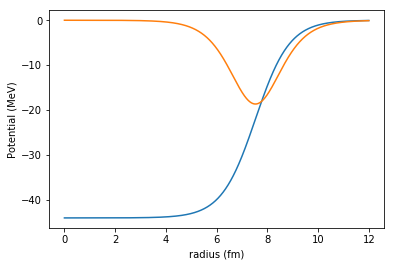

In [5]:
x = np.arange(0,12,0.01)

plt.plot(x, V*WoodsSaxton(x,R,a))
plt.plot(x, 50*DerivWoodsSaxton(x,R,a))
plt.xlabel("radius (fm)")
plt.ylabel("Potential (MeV)")
plt.show()

Next we must handle the kinetic energy term of the hamiltonian. This is a second derivative in radial position (when we use a wavefunction multiplied by the radius). Here we use the second order finite difference method to analytically calculate the derivative, which is defined as

$$ u''(x) = \frac{u(x+h) + u(x-h) - 2u(x)}{h^2} + O(h^2)$$

where the error $O(h^2)$ is scaled with the square of the step size h. This requires the descritization of the position space. After descritization, we setup and solve the eigenvalue problem given below.

$$
\begin{bmatrix}
    [3,1] + V & -1 & 0 & \dots & \dots & 0 \\
    -1 & 2 + V & -1 & 0 & \dots  & \dots \\
    0 &-1 & 2 + V & -1 & 0  & \dots \\
    0 & \dots & \ddots & \ddots & \ddots & 0 \\
    0 & \dots & \dots& -1 & 2 + V & -1 \\
    0 & \dots & \dots & \dots& -1 & 2 + V
\end{bmatrix} * U(r,n,l,m) = E*U(r,n,l,m)    $$

(where it is 3 if $l$=even and 1 if $l$=odd)

In [6]:
# descritize the problem
n = 1000

r_min = 0
r_max = 15

h = (r_max-r_min)/n
print(h)

0.015


In [7]:
def MakeTriDiag(j,l,s):
    A = np.zeros((n,n))
#     r_array = np.arange(r_min + 0.5*h, r_max, h)
    
    for i in range(n):
        # derterimine the current radius
        ri = r_min + h*(i+0.5)
        # determine the potential at that radius
        Pot = V*WoodsSaxton(ri,R,a) + AngularMom(ri,l) + SpinOrbit(j,l,s,ri,R,a)

        # Check if it is an edge case
        if i == 0: # first row
            if l%2 == 0: # even L
                A[i][i] = -3*c/h**2 + Pot
                A[i][i+1] = c/h**2
            if l%2 == 1: # odd L
                A[i][i] = -c/h**2 + Pot
                A[i][i+1] = c/h**2 

        elif i == (len(A)-1): # last row
            if l%2 == 0: # even L
                A[i][i] = -2*c/h**2 + Pot
                A[i][i-1] = c/h**2
            if l%2 == 1: # odd L
                A[i][i] = -2*c/h**2 + Pot
                A[i][i-1] = c/h**2

        else:
            # Build the Tridiagonal section of the matrix
            A[i][i] = -2*c/h**2 + Pot
            A[i][i+1] = c/h**2
            A[i][i-1] = c/h**2
    
    return A
            
j = 1.5
l = 1
s = 0.5
A = MakeTriDiag(j,l,s)

In [8]:
# Find the eigen values of the matrix A because the eigen values are the energy 
# while the eigenvectors are the wavefuctions*r as a function of r
vals, vect = np.linalg.eigh(A)


0p1.5 Energy=-36.1206
1p1.5 Energy=-23.3499
2p1.5 Energy=-8.1976


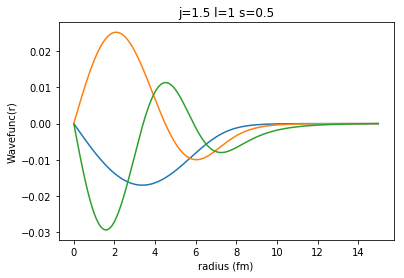

In [9]:
# Search through all the eigenvalues and find the values below 0 as those are the bound states
def getvalues(j,l,s,vals,vect,plot):
    vect = vect.T
    r_array = np.arange(r_min + 0.5*h, r_max, h)
    specnot = {0:"s",1:"p",2:"d",3:'f',4:"g",5:"h",6:"i",7:"j"}
    i = 0
    # have a list of sorted values so it is easy to find the lowest energies
    vals_ordered = np.sort(vals)
    while vals_ordered[i] < 0: # energy < 0 is a bound state
        print("{}{}{} Energy={}".format(i,specnot[l],j,round(vals_ordered[i],4)))
        if plot:
            # find the index in the unorderd so the 
            index = np.where(vals == vals_ordered[i])
            plt.plot(r_array, (vect[index][0]/r_array))
        i += 1
    if plot:
        plt.title("j={} l={} s={}".format(j,l,s))
        plt.xlabel("radius (fm)")
        plt.ylabel("Wavefunc(r)")
        plt.show()

getvalues(j,l,s,vals,vect,True)

## The Results ##
These numbers can be compared to the [following site](https://web.physics.wustl.edu/~wimd/bomo_levels_208Pb.pdf)

The last step is to loop over all posible values of $l$ and $s$ to determine the energies of those states

In [10]:
n = 2000
r_min = 0
r_max = 15
h = (r_max-r_min)/n

for l in range(8):
    for s in [0.5,-0.5]:
        j = l + s
        if j < 0:
            continue
        A = MakeTriDiag(j,l,s)
        vals, vect = np.linalg.eigh(A)
        #change T/F based on if you want plots of the wavefunctions
        getvalues(j,l,s,vals,vect,False)


0s0.5 Energy=-39.9586
1s0.5 Energy=-29.4796
2s0.5 Energy=-15.1813
3s0.5 Energy=-1.1521
0p1.5 Energy=-36.1205
1p1.5 Energy=-23.3498
2p1.5 Energy=-8.1972
0p0.5 Energy=-35.8721
1p0.5 Energy=-22.8595
2p0.5 Energy=-7.5968
0d2.5 Energy=-31.5969
1d2.5 Energy=-16.9355
2d2.5 Energy=-1.8436
0d1.5 Energy=-30.8605
1d1.5 Energy=-15.7615
2d1.5 Energy=-0.8142
0f3.5 Energy=-26.4997
1f3.5 Energy=-10.3511
0f2.5 Energy=-25.0214
1f2.5 Energy=-8.3802
0g4.5 Energy=-20.9116
1g4.5 Energy=-3.7573
0g3.5 Energy=-18.4405
1g3.5 Energy=-1.0573
0h5.5 Energy=-14.8982
0h4.5 Energy=-11.2056
0i6.5 Energy=-8.5158
0i5.5 Energy=-3.4241
0j7.5 Energy=-1.8203
